### Imports

In [1]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    import optuna
    import torch
    import os
    import random
    random.seed(3111)
    import h5py
    import matplotlib.pyplot as plt
    import numpy as np
    from torch.nn.functional import mse_loss
    from simulai.math.integration import LSODA, ClassWrapper
    from simulai.math.differentiation import CollocationDerivative
    from simulai.rom import POD
    from simulai.io import Reshaper
    from simulai.simulation import Pipeline
    from simulai.regression import OpInf
    import vtk
# Adjustment to numpy's error/warning handling for floating point operations
# np.seterr(over='raise', invalid='raise')
os.chdir(os.path.split(os.getcwd())[0]) # change directory

### Read data

In [2]:
with h5py.File(".\\dataset\\OpInfData.h5", 'r') as f:
  # raw data is matrix with 'timestep' rows
  # and 'nodal pressure' columns
  opInfData = np.array(f["standardData"], dtype = np.float32)[:-1]
  # node coordinates is 2 x 'number of nodes' matrix.
  # first row is x; second, y
  nodeCoord = np.array(f["nodeCoords"], dtype = np.float32)
  # node mesh connectivity
  nodeConn = np.array(f["nodeConnectivity"], dtype = np.int32)
for var in [opInfData, nodeCoord, nodeConn]:
  print(type(var))
  print(var.shape)

<class 'numpy.ndarray'>
(10050, 3362)
<class 'numpy.ndarray'>
(2, 3362)
<class 'numpy.ndarray'>
(12672,)


### POD

Dimension reduction using Proper Orthogonal Decomposition

In [3]:
# Instantiating a Pipeline to prepare data
rom_config = {'n_components': 100} # new number of dimensions
pipeline = Pipeline(
  stages = [('data_preparer', Reshaper()),
  ('rom', POD(config = rom_config))]
)
# Executing the workflow
pipeline.exec(input_data = opInfData)
projectedData = pipeline.project_data(data = opInfData)
reconstructedData = pipeline.reconstruct_data(data = projectedData)
print(f"\nraw data shape: {opInfData.shape}")
print(f"projectedData shape: {projectedData.shape}")
print(f"reconstructedData shape: {reconstructedData.shape}")
print("Reconstruction MSE = {:.4e}".format(mse_loss(
    torch.tensor(reconstructedData), torch.tensor(opInfData)
).item()))

Executing a global pipeline.
Executed operation RESHAPER.
Relative contribution of the mean component: 0.00787135399878025
Relative Modal Energy 0.999042809009552
Executed operation POD.
Applying the global reconstruction strategy.

raw data shape: (10050, 3362)
projectedData shape: (10050, 100)
reconstructedData shape: (10050, 3362)
Reconstruction MSE = 7.9968e-04


### Data split
90\% used for training, and 10\% for testing

In [7]:
# timesteps
dt = 1.0 / 500 / 800
timeRange = np.arange(0, 10050 * dt, dt)
# augment dataset with estimates of time derivatives
diff = CollocationDerivative(config = {})
derivativeData = diff.solve(data = projectedData, x = timeRange)
# split dataset
splitIndex = np.int32(len(timeRange) * 0.75)
dataTrain = projectedData[:splitIndex]
dataTest = projectedData[splitIndex:]
dataDerivativeTrain = derivativeData[:splitIndex]
dataDerivativeTest = derivativeData[splitIndex:]
timeTrain = timeRange[:splitIndex]
timeTest = timeRange[splitIndex:]

print(f"dataTrain shape: {dataTrain.shape}")
print(f"dataTest shape: {dataTest.shape}")
print(f"dataDerivativeTrain shape: {dataDerivativeTrain.shape}")
print(f"dataDerivativeTest shape: {dataDerivativeTest.shape}")
print(f"timeTrain shape: {timeTrain.shape}")
print(f"timeTest shape: {timeTest.shape}")

Performing Collocation Derivation.
dataTrain shape: (7537, 100)
dataTest shape: (2513, 100)
dataDerivativeTrain shape: (7537, 100)
dataDerivativeTest shape: (2513, 100)
timeTrain shape: (7537,)
timeTest shape: (2513,)


### Best parameters
Hyperparameter optimization with the Optuna package to find the optimal combination of regularization weights.

In [8]:
# objective is a function which returns a scalar
# that must be minimized
def objective(trial):
    print("")
    # setup optimization parameters (regularization weights)
    lambdaLinear = trial.suggest_float('lambdaLinear', 0, 1e3, step = 50)
    lambdaQuad = trial.suggest_float('lambdaQuad', 0, 1e3, step = 50)
    # OpInf least squares minimization in embedded space
    _opInfObject = OpInf(bias_rescale = 1e-15, solver = 'lstsq')
    _opInfObject.set(lambda_linear = lambdaLinear, lambda_quadratic = lambdaQuad)
    _opInfObject.fit(input_data = dataTrain, target_data = dataDerivativeTrain)
    # Time integration through test time interval
    _opInfObject.construct_K_op()
    _rightOperator = ClassWrapper(_opInfObject)
    _solver = LSODA(_rightOperator)
    _testIntegration = _solver.run(dataTrain[-1], timeTest)
    # return MSE of time integration in test split
    print("")
    return np.square(np.subtract(_testIntegration, dataTest)).mean()
# create study object with desired sampler
study = optuna.create_study(
    sampler = optuna.samplers.RandomSampler()
    # sampler = optuna.samplers.CmaEsSampler()
    # sampler = optuna.samplers.QMCSampler()
)
# run optimization
study.optimize(objective, n_trials = 30, show_progress_bar = True)
# results
print(f"\nBest Parameters: {study.best_params}")
print(f"Best objective value: {study.best_value}")

[I 2023-07-05 22:22:07,427] A new study created in memory with name: no-name-9314d523-45db-4158-ab5b-118ba812d7ad
  0%|          | 0/30 [00:00<?, ?it/s]


Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 8.41499:   3%|▎         | 1/30 [00:45<22:01, 45.55s/it]


[I 2023-07-05 22:22:52,981] Trial 0 finished with value: 8.414987390480881 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 1000.0}. Best is trial 0 with value: 8.414987390480881.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 8.41499:   7%|▋         | 2/30 [01:32<21:45, 46.62s/it]


[I 2023-07-05 22:23:40,344] Trial 1 finished with value: 9.89923244543081 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 300.0}. Best is trial 0 with value: 8.414987390480881.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 8.41499:  10%|█         | 3/30 [02:19<21:00, 46.67s/it]


[I 2023-07-05 22:24:27,073] Trial 2 finished with value: 13.57450069780898 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 100.0}. Best is trial 0 with value: 8.414987390480881.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 8.41499:  13%|█▎        | 4/30 [03:05<20:09, 46.53s/it]


[I 2023-07-05 22:25:13,380] Trial 3 finished with value: 12.427953930773043 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 150.0}. Best is trial 0 with value: 8.414987390480881.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 8.41499:  17%|█▋        | 5/30 [03:54<19:38, 47.14s/it]


[I 2023-07-05 22:26:01,615] Trial 4 finished with value: 9.911949502906646 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 300.0}. Best is trial 0 with value: 8.414987390480881.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Best trial: 0. Best value: 8.41499:  20%|██        | 6/30 [04:42<19:04, 47.68s/it]


[I 2023-07-05 22:26:50,341] Trial 5 finished with value: 9.713206590501615e+24 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 700.0}. Best is trial 0 with value: 8.414987390480881.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 6. Best value: 8.38131:  23%|██▎       | 7/30 [05:33<18:37, 48.58s/it]


[I 2023-07-05 22:27:40,767] Trial 6 finished with value: 8.381312759383542 and parameters: {'lambdaLinear': 400.0, 'lambdaQuad': 900.0}. Best is trial 6 with value: 8.381312759383542.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 6. Best value: 8.38131:  27%|██▋       | 8/30 [06:22<17:50, 48.67s/it]


[I 2023-07-05 22:28:29,624] Trial 7 finished with value: 11.513318688143068 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 200.0}. Best is trial 6 with value: 8.381312759383542.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.
Using jacobian: stiffness alert.


Using jacobian: stiffness alert.



Best trial: 6. Best value: 8.38131:  30%|███       | 9/30 [07:11<17:07, 48.92s/it]

[I 2023-07-05 22:29:18,911] Trial 8 finished with value: 7011986471176.229 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 0.0}. Best is trial 6 with value: 8.381312759383542.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 6. Best value: 8.38131:  33%|███▎      | 10/30 [07:59<16:09, 48.47s/it]


[I 2023-07-05 22:30:06,563] Trial 9 finished with value: 9.9012342851582 and parameters: {'lambdaLinear': 800.0, 'lambdaQuad': 300.0}. Best is trial 6 with value: 8.381312759383542.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 6. Best value: 8.38131:  37%|███▋      | 11/30 [08:46<15:15, 48.17s/it]


[I 2023-07-05 22:30:54,063] Trial 10 finished with value: 4.283704864334742e+20 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 50.0}. Best is trial 6 with value: 8.381312759383542.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 6. Best value: 8.38131:  40%|████      | 12/30 [09:33<14:18, 47.68s/it]


[I 2023-07-05 22:31:40,626] Trial 11 finished with value: 13.529393975489524 and parameters: {'lambdaLinear': 450.0, 'lambdaQuad': 100.0}. Best is trial 6 with value: 8.381312759383542.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 6. Best value: 8.38131:  43%|████▎     | 13/30 [10:18<13:20, 47.07s/it]


[I 2023-07-05 22:32:26,294] Trial 12 finished with value: 9.898756394436107 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 300.0}. Best is trial 6 with value: 8.381312759383542.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 6. Best value: 8.38131:  47%|████▋     | 14/30 [11:05<12:30, 46.93s/it]


[I 2023-07-05 22:33:12,905] Trial 13 finished with value: 13.534681540963208 and parameters: {'lambdaLinear': 250.0, 'lambdaQuad': 100.0}. Best is trial 6 with value: 8.381312759383542.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 6. Best value: 8.38131:  50%|█████     | 15/30 [11:52<11:45, 47.05s/it]


[I 2023-07-05 22:34:00,227] Trial 14 finished with value: 13.52756069034538 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 100.0}. Best is trial 6 with value: 8.381312759383542.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 6. Best value: 8.38131:  53%|█████▎    | 16/30 [12:39<10:57, 46.94s/it]


[I 2023-07-05 22:34:46,900] Trial 15 finished with value: 4.044236614819622e+20 and parameters: {'lambdaLinear': 450.0, 'lambdaQuad': 50.0}. Best is trial 6 with value: 8.381312759383542.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 6. Best value: 8.38131:  57%|█████▋    | 17/30 [13:26<10:11, 47.05s/it]


[I 2023-07-05 22:35:34,200] Trial 16 finished with value: 4.017932598427748e+20 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 50.0}. Best is trial 6 with value: 8.381312759383542.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 6. Best value: 8.38131:  60%|██████    | 18/30 [14:12<09:21, 46.78s/it]


[I 2023-07-05 22:36:20,357] Trial 17 finished with value: 9.91606446964097 and parameters: {'lambdaLinear': 450.0, 'lambdaQuad': 300.0}. Best is trial 6 with value: 8.381312759383542.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 6. Best value: 8.38131:  63%|██████▎   | 19/30 [15:03<08:47, 48.00s/it]


[I 2023-07-05 22:37:11,195] Trial 18 finished with value: 8.948875650982867 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 600.0}. Best is trial 6 with value: 8.381312759383542.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 6. Best value: 8.38131:  67%|██████▋   | 20/30 [15:49<07:52, 47.22s/it]


[I 2023-07-05 22:37:56,596] Trial 19 finished with value: 9.311499974008855 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 350.0}. Best is trial 6 with value: 8.381312759383542.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 6. Best value: 8.38131:  70%|███████   | 21/30 [16:32<06:54, 46.01s/it]


[I 2023-07-05 22:38:39,799] Trial 20 finished with value: 11.733770580155523 and parameters: {'lambdaLinear': 50.0, 'lambdaQuad': 250.0}. Best is trial 6 with value: 8.381312759383542.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 6. Best value: 8.38131:  73%|███████▎  | 22/30 [17:16<06:03, 45.48s/it]


[I 2023-07-05 22:39:24,044] Trial 21 finished with value: 11.492367476707145 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 200.0}. Best is trial 6 with value: 8.381312759383542.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 22. Best value: 8.28914:  77%|███████▋  | 23/30 [18:00<05:14, 44.91s/it]


[I 2023-07-05 22:40:07,606] Trial 22 finished with value: 8.289143916744347 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 900.0}. Best is trial 22 with value: 8.289143916744347.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 23. Best value: 8.23622:  80%|████████  | 24/30 [18:42<04:25, 44.25s/it]


[I 2023-07-05 22:40:50,323] Trial 23 finished with value: 8.236219172319746 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 850.0}. Best is trial 23 with value: 8.236219172319746.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 23. Best value: 8.23622:  83%|████████▎ | 25/30 [19:25<03:38, 43.80s/it]


[I 2023-07-05 22:41:33,059] Trial 24 finished with value: 8.33007007988177 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 900.0}. Best is trial 23 with value: 8.236219172319746.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 23. Best value: 8.23622:  87%|████████▋ | 26/30 [20:10<02:56, 44.23s/it]


[I 2023-07-05 22:42:18,305] Trial 25 finished with value: 9.277485131686669 and parameters: {'lambdaLinear': 800.0, 'lambdaQuad': 350.0}. Best is trial 23 with value: 8.236219172319746.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 23. Best value: 8.23622:  90%|█████████ | 27/30 [20:55<02:12, 44.24s/it]


[I 2023-07-05 22:43:02,560] Trial 26 finished with value: 10.630703592746542 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 250.0}. Best is trial 23 with value: 8.236219172319746.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 23. Best value: 8.23622:  93%|█████████▎| 28/30 [21:38<01:27, 43.87s/it]


[I 2023-07-05 22:43:45,566] Trial 27 finished with value: 8.32637568812075 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 500.0}. Best is trial 23 with value: 8.236219172319746.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 23. Best value: 8.23622:  97%|█████████▋| 29/30 [22:21<00:43, 43.78s/it]


[I 2023-07-05 22:44:29,139] Trial 28 finished with value: 8.713302452091602 and parameters: {'lambdaLinear': 200.0, 'lambdaQuad': 450.0}. Best is trial 23 with value: 8.236219172319746.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 8.16134: 100%|██████████| 30/30 [23:04<00:00, 46.16s/it]


[I 2023-07-05 22:45:12,181] Trial 29 finished with value: 8.16133671351066 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 650.0}. Best is trial 29 with value: 8.16133671351066.

Best Parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 650.0}
Best objective value: 8.16133671351066


Experiments were conducted to choose between the samplers RandomSampler, CmaEsSampler and QMCSampler (1h, 90 trials each). Random sampler achieved the smallest test interval MSE.

### OpInf fitting
OpInf least squares minimization in projected space. Find optimal coefficients of quadratic system of ODEs in projected space.

In [9]:
# create OpInf object
opInfObject = OpInf(bias_rescale = 1e-15, solver = 'lstsq')
# set optimal regularization weights from previous step
opInfObject.set(
    lambda_linear = study.best_params["lambdaLinear"],
    # lambda_linear = 600,
    lambda_quadratic = study.best_params["lambdaQuad"]
    # lambda_quadratic = 250
)
# least squares fit
opInfObject.fit(input_data = dataTrain, target_data = dataDerivativeTrain)

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


### Time integration
Integrate in time the ODE system approximated in the previous code cell. Start in the last time step of the training split, and integrate through the test split

In [10]:
opInfObject.construct_K_op()
rightOperator = ClassWrapper(opInfObject)
solver = LSODA(rightOperator)
testIntegration = solver.run(dataTrain[-1], timeTest)
# output is matrix with 'test time steps' rows and
# 'embedded dimensions' columns. Represents field evolution
# throughout time steps in test split (in projected space)
print(f"testIntegration shape: {testIntegration.shape}")
# After time integration, return to original high dimensional space
reconstructIntTest = pipeline.reconstruct_data(data = testIntegration)
print(f"reconstructIntTest shape: {reconstructIntTest.shape}")

testIntegration shape: (2513, 100)
Applying the global reconstruction strategy.
reconstructIntTest shape: (2513, 3362)


### Model error

In [11]:
# MSE of time integration over test split in embedded space
mseLowDim = mse_loss(torch.tensor(testIntegration), torch.tensor(dataTest))
print("Reduced order MSE = {:.4e}".format(mseLowDim.item()))
# MSE of time integration over test split in original space
mseHighDim = mse_loss(torch.tensor(reconstructIntTest), torch.tensor(opInfData[splitIndex:]))
print("Full order MSE = {:.4e}".format(mseHighDim.item()))

Reduced order MSE = 8.1613e+00
Full order MSE = 2.4472e-01


### Integration error history
Sample some positions and plot their time integration error histories

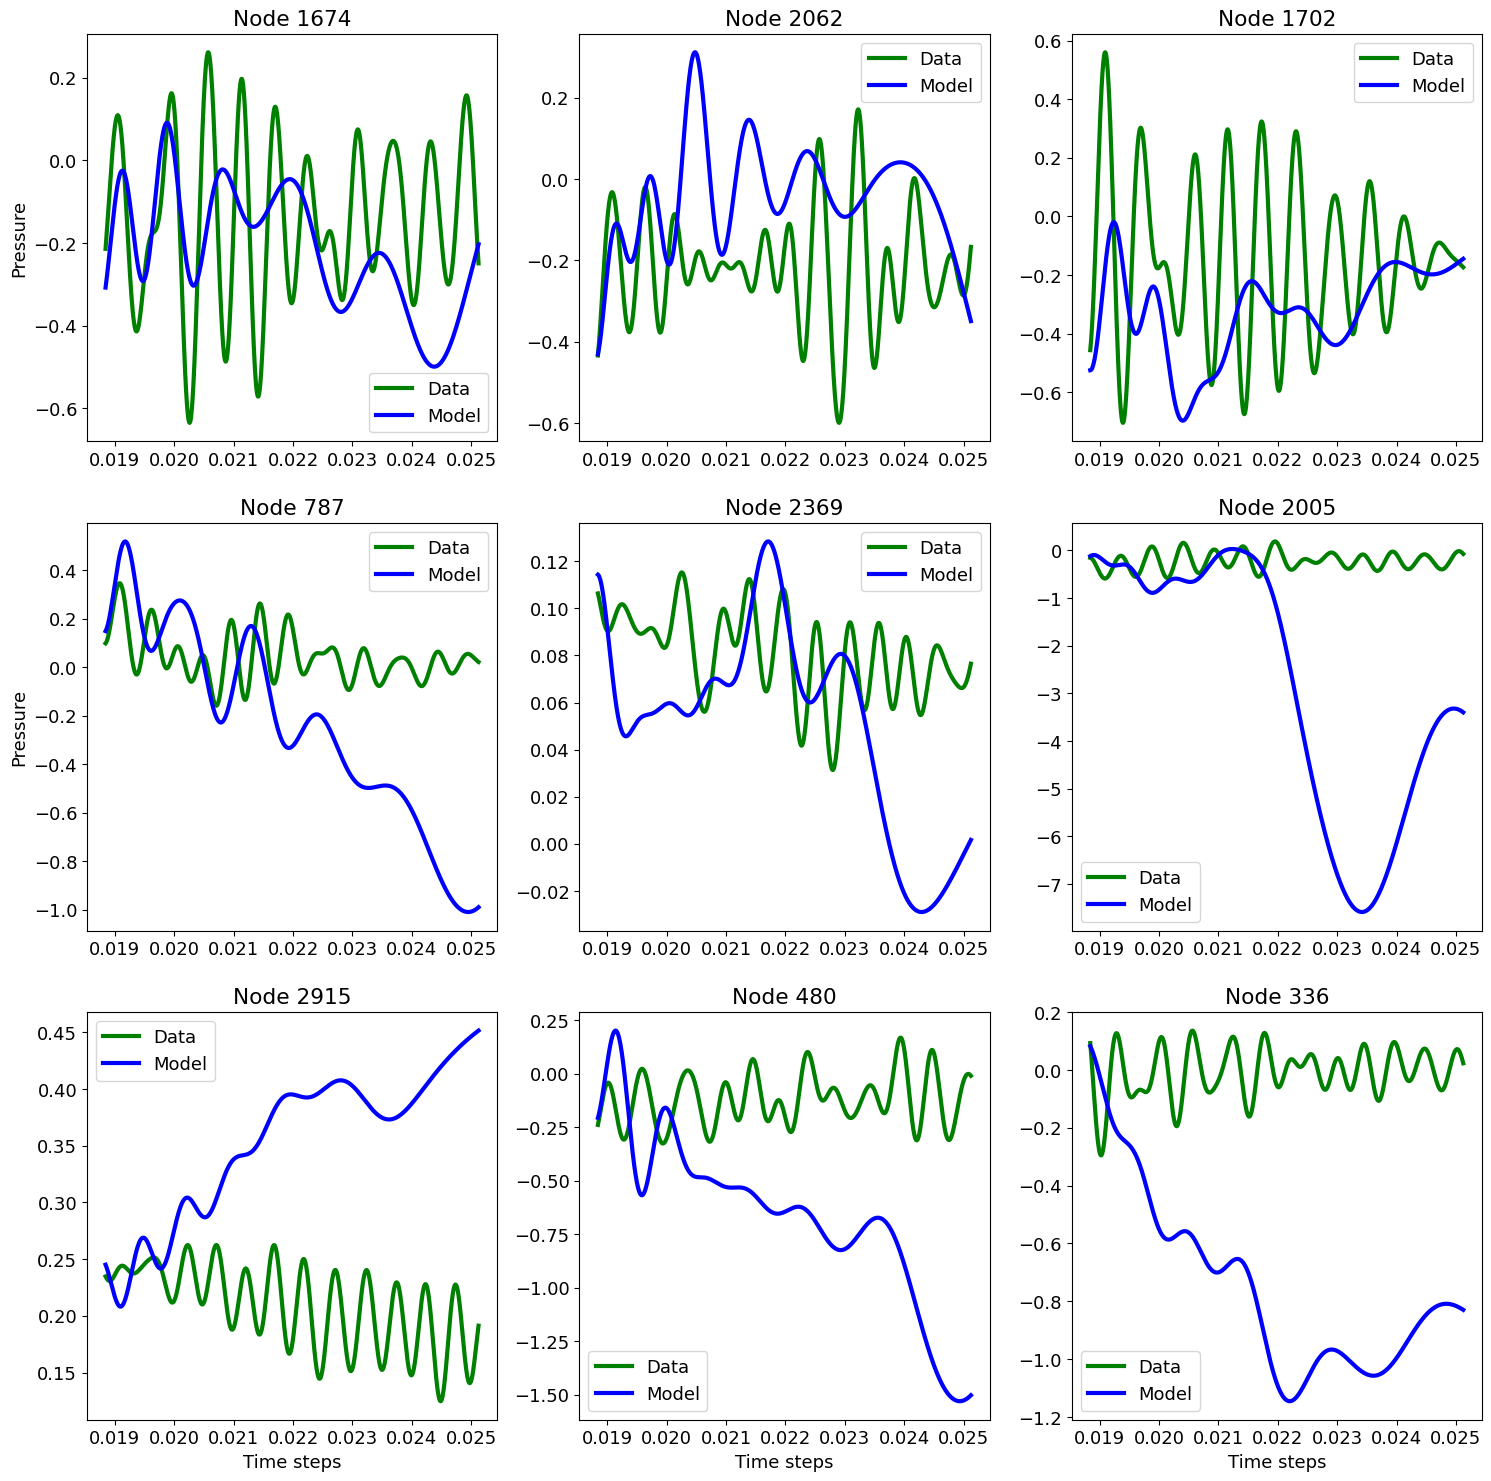

In [15]:
plt.rcParams['font.size'] = 13
# choose random points in physical domain
points = random.sample(range(opInfData.shape[1]), k = 9)
# create figure. 'ax' is (3, 3) array of Axes
fig, ax = plt.subplots(3, 3, figsize = (18, 18))
# iterate in subplots
for (plotID, (axis, point)) in enumerate(zip(ax.flatten(), points)):
  axis.plot(timeTest, opInfData[-timeTest.shape[0]:, point],
    label = "Data", color = 'green', linewidth = 3
  )
  axis.plot(timeTest, reconstructIntTest[-timeTest.shape[0]:, point],
    label = "Model", color = 'blue', linewidth = 3
  )
  axis.set_title(f"Node {point}")
  axis.legend()
  if plotID in [6, 7, 8]:
    axis.set_xlabel("Time steps")
  elif plotID in [0, 3, 6]:
    axis.set_ylabel("Pressure")

### Reconstruction error
Sample some points and plot their reconstruction error histories in the train split

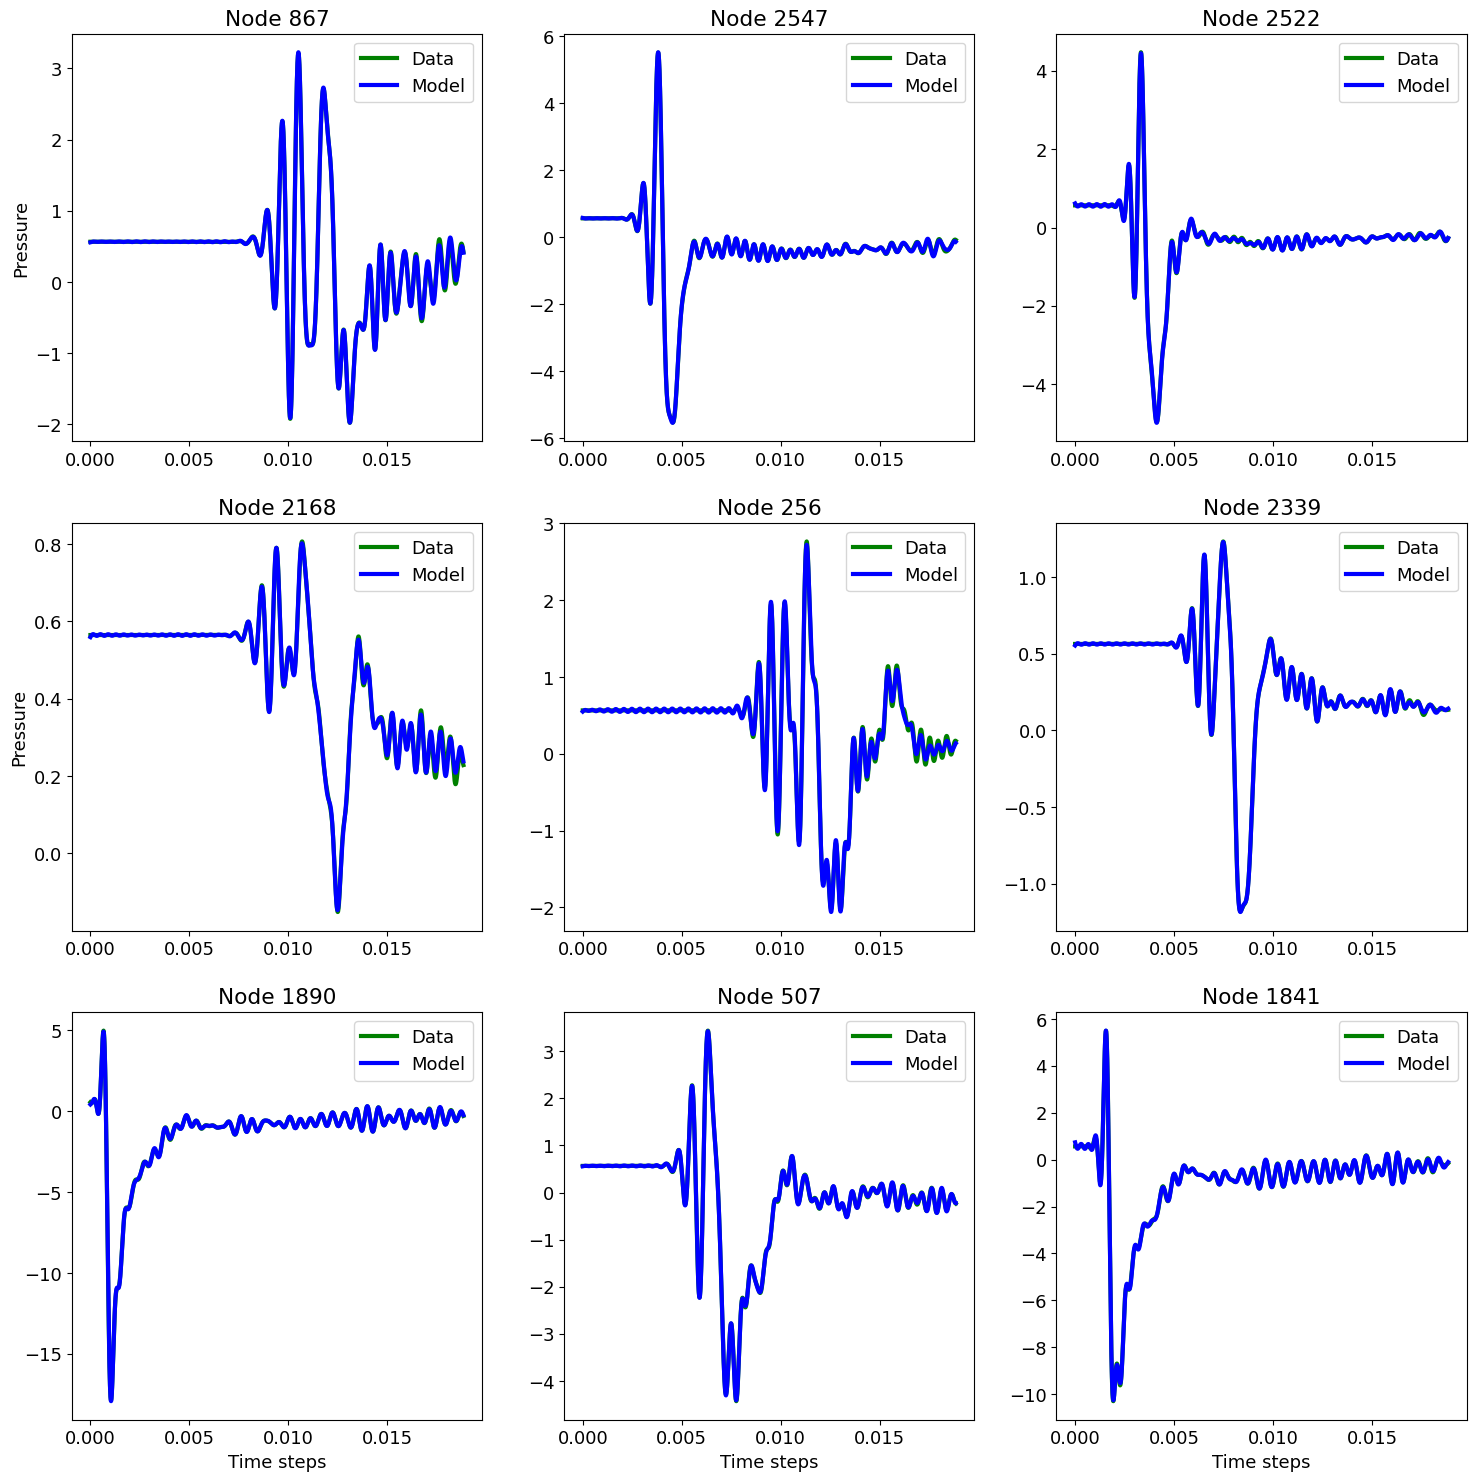

In [16]:
# choose random points in physical domain
points = random.sample(range(opInfData.shape[1]), k = 9)
# create figure. 'ax' is (3, 3) array of Axes
fig, ax = plt.subplots(3, 3, figsize = (18, 18))
# iterate in subplots
for (plotID, (axis, point)) in enumerate(zip(ax.flatten(), points)):
  axis.plot(timeTrain, opInfData[:timeTrain.shape[0]:, point],
    label = "Data", color = 'green', linewidth = 3
  )
  axis.plot(timeTrain, reconstructedData[:timeTrain.shape[0]:, point],
    label = "Model", color = 'blue', linewidth = 3
  )
  axis.set_title(f"Node {point}")
  axis.legend()
  if plotID in [6, 7, 8]:
    axis.set_xlabel("Time steps")
  elif plotID in [0, 3, 6]:
    axis.set_ylabel("Pressure")

### Animation

In [14]:
nodeConn = nodeConn - 1
for step in range(reconstructIntTest.shape[0]):
    # create vtk object
    my_vtk_dataset = vtk.vtkUnstructuredGrid()
    # create points by defining coordinates
    points = vtk.vtkPoints()
    for id in range(reconstructIntTest.shape[1]):
        points.InsertPoint(id, [nodeCoord[0, id], nodeCoord[1, id], 0])
    my_vtk_dataset.SetPoints(points)
    # create elements by establishing connectivity
    my_vtk_dataset.Allocate(3168)
    for elementID in range(3168):
        my_vtk_dataset.InsertNextCell(
            vtk.VTK_QUAD, 4,
            np.asarray(nodeConn[4 * elementID : 4 * (elementID + 1)])
        )
    # create data arrays
    array = vtk.vtkDoubleArray()
    array.SetNumberOfComponents(1)
    array.SetNumberOfTuples(reconstructIntTest.shape[1])
    array.SetName('pressure')
    for id in range(reconstructIntTest.shape[1]):
        array.SetTuple(id, [reconstructIntTest[step, id]])
    my_vtk_dataset.GetPointData().AddArray(array)
    # save data to disk
    writer = vtk.vtkXMLUnstructuredGridWriter()
    writer.SetFileName(f"./animation/vtk/output-{step}.vtu")
    writer.SetInputData(my_vtk_dataset)
    writer.Write()